# Classification model for air quality prediction in time

⚠️ Some parts of this notebook are the same as `regression_main.ipynb`. The traffic part is the exact same, so is still regression. I suppressed most of the output of the traffic prediction model training/validation as it is duplicate.

The classification part intervenes in the air quality prediction.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier
import plotly.graph_objects as go
from scipy.stats import mode
import seaborn as sns


Loading the dataset for classification

In [2]:
df=pd.read_pickle("created_dataset_classes.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16081 entries, 0 to 16080
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           16081 non-null  object        
 1   hour           16081 non-null  int32         
 2   traffic_z0     16081 non-null  float64       
 3   traffic_z1     16081 non-null  float64       
 4   traffic_z3     16081 non-null  float64       
 5   traffic_z4     16081 non-null  float64       
 6   traffic_z5     16081 non-null  float64       
 7   traffic_z6     16081 non-null  float64       
 8   traffic_z7     16081 non-null  float64       
 9   traffic_z8     16081 non-null  float64       
 10  station_4      16081 non-null  object        
 11  station_43     16081 non-null  object        
 12  station_44     16081 non-null  object        
 13  station_54     16081 non-null  object        
 14  station_57     16081 non-null  object        
 15  station_58     1608

We will predict both traffic and air quality in the future. Here is the number of hours in the future the prediction will be made.

In [3]:
forecast_h = 12 # Prediction will be made for forecast_h hours in the future

# Predicting traffic

In [4]:
# Identifying the 'traffic_zN' columns
traffic_cols = [c for c in df.columns if c.startswith("traffic_")]

# Creating the target value (value forecast_h hours after) for every traffic area
for col in traffic_cols:
    df[f"target_{col}"] = df[col].shift(-forecast_h)

# This functions add lags (values from previous hours) and rolls (previous rolling means over time windows)
def add_lags_and_rolls(df, cols, lags=[1, 2, 3, 6, 12], rolls=[3, 6, 12]):
    for col in cols:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
        for w in rolls:
            df[f"{col}_roll{w}"] = df[col].rolling(window=w).mean()
    return df

df = add_lags_and_rolls(df, traffic_cols)
df["dayofweek"] = df["datetime_hour"].dt.dayofweek
df = df.dropna().reset_index(drop=True)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16057 entries, 0 to 16056
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               16057 non-null  object        
 1   hour               16057 non-null  int32         
 2   traffic_z0         16057 non-null  float64       
 3   traffic_z1         16057 non-null  float64       
 4   traffic_z3         16057 non-null  float64       
 5   traffic_z4         16057 non-null  float64       
 6   traffic_z5         16057 non-null  float64       
 7   traffic_z6         16057 non-null  float64       
 8   traffic_z7         16057 non-null  float64       
 9   traffic_z8         16057 non-null  float64       
 10  station_4          16057 non-null  object        
 11  station_43         16057 non-null  object        
 12  station_44         16057 non-null  object        
 13  station_54         16057 non-null  object        
 14  statio

Training of one model per zone

In [5]:
models_traffic = {}
scalers_traffic = {}
for col in traffic_cols:
    # Features : lags/rolling de la zone + temporel
    feature_cols = [c for c in df.columns if c.startswith(f"{col}_") or c in ["hour", "dayofweek"]]
    X = df[feature_cols]
    y = df[f"target_{col}"]

    # Split train/test
    split_idx = int(len(df) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Normalisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers_traffic[col] = scaler

    # Model
    model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbose=-1) # verbose=-1 for no output
    model.fit(X_train_scaled, y_train)
    models_traffic[col] = model

"""     Suppress the testing output
    # Metrics
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    #print(f"[TRAFFIC] {col}: MAE = {mae:.2f}, R² = {r2:.3f}")

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df["datetime_hour"].iloc[split_idx:],
        y=y_test,
        mode='lines',
        name='VReal values',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=df["datetime_hour"].iloc[split_idx:],
        y=y_pred,
        mode='lines',
        name='Prédictions',
        line=dict(color='red', dash='dash')
    ))
    fig.update_layout(
        title=f"Traffic prediction in ({col}) for +{forecast_h}h",
        xaxis_title="Date",
        yaxis_title="Traffic",
        hovermode="x unified",
        template="plotly_white"
    )
    fig.show() """


'     Suppress the testing output\n    # Metrics\n    y_pred = model.predict(X_test_scaled)\n    mae = mean_absolute_error(y_test, y_pred)\n    r2 = r2_score(y_test, y_pred)\n    #print(f"[TRAFFIC] {col}: MAE = {mae:.2f}, R² = {r2:.3f}")\n\n    fig = go.Figure()\n    fig.add_trace(go.Scatter(\n        x=df["datetime_hour"].iloc[split_idx:],\n        y=y_test,\n        mode=\'lines\',\n        name=\'VReal values\',\n        line=dict(color=\'blue\')\n    ))\n    fig.add_trace(go.Scatter(\n        x=df["datetime_hour"].iloc[split_idx:],\n        y=y_pred,\n        mode=\'lines\',\n        name=\'Prédictions\',\n        line=dict(color=\'red\', dash=\'dash\')\n    ))\n    fig.update_layout(\n        title=f"Traffic prediction in ({col}) for +{forecast_h}h",\n        xaxis_title="Date",\n        yaxis_title="Traffic",\n        hovermode="x unified",\n        template="plotly_white"\n    )\n    fig.show() '

# Predicting air quality
First with real traffic values. (Later I will use the predicted ones)

In [6]:
print(df.info())

# Identify the station cols
station_cols = [c for c in df.columns if c.startswith("station_")]
weather_cols = ["temperature", "wind_u", "wind_v", "precipitation", "is_raining", "humidity", "pressure", "cloud_cover"]
weather_cols = [c for c in weather_cols if c in df.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16057 entries, 0 to 16056
Data columns (total 98 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               16057 non-null  object        
 1   hour               16057 non-null  int32         
 2   traffic_z0         16057 non-null  float64       
 3   traffic_z1         16057 non-null  float64       
 4   traffic_z3         16057 non-null  float64       
 5   traffic_z4         16057 non-null  float64       
 6   traffic_z5         16057 non-null  float64       
 7   traffic_z6         16057 non-null  float64       
 8   traffic_z7         16057 non-null  float64       
 9   traffic_z8         16057 non-null  float64       
 10  station_4          16057 non-null  object        
 11  station_43         16057 non-null  object        
 12  station_44         16057 non-null  object        
 13  station_54         16057 non-null  object        
 14  statio

Creation of the `target column`: this is the value we will try to predict for a given hour. It is the air quality labeled by station 4 in `forecast_h` hours.

In [7]:
# Target: Can be either the mean of all the stations, or one specific station.


target, target_label = df[['station_4']], "Air quality in station 4"

In [8]:
df["air_quality_selected"] = target
df["target_air_quality"] = df["air_quality_selected"].shift(-forecast_h)



# We can't add rolls of classes as in add_lags_and_rolls, so instead I will add modes (most frequent label over a period)
def add_lags_and_modes(df, cols, lags=[1, 2, 3, 6, 12], windows=[3, 6, 12]):
    for col in cols:
        # Adding lags
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)
        # Adding rolling modes
        for w in windows:
            df[f"{col}_mode{w}"] = None  # Init a column to store the mode
            for i in range(len(df)):
                start = max(0, i - w + 1)
                window = df[col].iloc[start:i+1]                
                # calculer le mode avec pands
                mode_result = window.mode()
                if not mode_result.empty:
                    current_mode = mode_result.iloc[0]
                    df.at[i, f"{col}_mode{w}"] = current_mode
                else:
                    # Utiliser la dernière valeur valide
                    last_valid = window.last_valid_index()
                    if last_valid is not None:
                        df.at[i, f"{col}_mode{w}"] = df[col].iloc[last_valid]
                        print(f"    Utilisation de la dernière valeur valide: {df[col].iloc[last_valid]}")
    return df


# Create Lags/rolling for air_quality + weather
df = add_lags_and_modes(df, ["air_quality_selected"] + weather_cols)
df = df.dropna().reset_index(drop=True) # By creating lags, we will loose forecast_h rows

"""# Ajout des prédictions de trafic (ou des données réelles)
use_predicted_traffic = True  # Option true/False
 if use_predicted_traffic:
    for col in traffic_cols:
        # Prédire le trafic pour toute la période (exemple simplifié..)
        feature_cols = [c for c in df.columns if c.startswith(f"{col}_") or c in ["hour", "dayofweek"]]
        X_traffic = df[feature_cols]
        X_traffic_scaled = scalers_traffic[col].transform(X_traffic)
        df[f"predicted_{col}"] = models_traffic[col].predict(X_traffic_scaled)
    traffic_features = [f"predicted_{col}" for col in traffic_cols]
else:
    traffic_features = traffic_cols """
traffic_features = traffic_cols

In [9]:
# Get the created features names
feature_cols_air = (
    traffic_features +
    [c for c in df.columns if any(x in c for x in ["_lag", "_mode"]) and "air_quality" in c] +
    [c for c in df.columns if any(x in c for x in ["_lag", "_mode"]) and c.split("_")[0] in weather_cols] +
    ["hour", "dayofweek"]
)

print(feature_cols_air)

['traffic_z0', 'traffic_z1', 'traffic_z3', 'traffic_z4', 'traffic_z5', 'traffic_z6', 'traffic_z7', 'traffic_z8', 'air_quality_selected_lag1', 'air_quality_selected_lag2', 'air_quality_selected_lag3', 'air_quality_selected_lag6', 'air_quality_selected_lag12', 'air_quality_selected_mode3', 'air_quality_selected_mode6', 'air_quality_selected_mode12', 'temperature_lag1', 'temperature_lag2', 'temperature_lag3', 'temperature_lag6', 'temperature_lag12', 'temperature_mode3', 'temperature_mode6', 'temperature_mode12', 'precipitation_lag1', 'precipitation_lag2', 'precipitation_lag3', 'precipitation_lag6', 'precipitation_lag12', 'precipitation_mode3', 'precipitation_mode6', 'precipitation_mode12', 'humidity_lag1', 'humidity_lag2', 'humidity_lag3', 'humidity_lag6', 'humidity_lag12', 'humidity_mode3', 'humidity_mode6', 'humidity_mode12', 'pressure_lag1', 'pressure_lag2', 'pressure_lag3', 'pressure_lag6', 'pressure_lag12', 'pressure_mode3', 'pressure_mode6', 'pressure_mode12', 'hour', 'dayofweek']


Splitting the dataset into a training dataset and testing other.
Since I need continous time, I can not pick randomly to fill these two new datasets. I chose to take the first 80% of the timeframe as training, and the remaining part as testing. This has some flaws (for example, the seasons change), I will try other ways later.

In [10]:
# Split train/test
print(df.info())
X = df[feature_cols_air]
y = df["target_air_quality"]

print(X.info())

split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


# Important: we removed some rows from X, we have to remove the corresponding ones from Y
y_test = y_test.loc[X_test.index]  # Have the same indexes as X_test
y_train = y_train.loc[X_train.index]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16033 entries, 0 to 16032
Columns: 172 entries, date to cloud_cover_mode12
dtypes: datetime64[ns](1), float64(125), int32(2), int64(3), object(41)
memory usage: 20.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16033 entries, 0 to 16032
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   traffic_z0                   16033 non-null  float64
 1   traffic_z1                   16033 non-null  float64
 2   traffic_z3                   16033 non-null  float64
 3   traffic_z4                   16033 non-null  float64
 4   traffic_z5                   16033 non-null  float64
 5   traffic_z6                   16033 non-null  float64
 6   traffic_z7                   16033 non-null  float64
 7   traffic_z8                   16033 non-null  float64
 8   air_quality_selected_lag1    16033 non-null  object 
 9   air_quality_selected_la

## Encoding the labels

We need to encode the labels as integers for processing

In [11]:
from sklearn.preprocessing import LabelEncoder

le_y = LabelEncoder()
# Encode y_train
y_train_encoded = le_y.fit_transform(y_train)

# Encode X_train and X_test
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in X_train_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train_encoded.loc[:, col] = le.fit_transform(X_train_encoded[col])
    # Convert the column to int type (not automatic)
    X_train_encoded[col] = X_train_encoded[col].astype(int)

for col in X_test_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_test_encoded.loc[:, col] = le.fit_transform(X_test_encoded[col])
    # Convert the column to int type (not automatic)
    X_test_encoded[col] = X_test_encoded[col].astype(int)


# No need to encode y_train, because I will decode the prediction.

Now, the training dataset (X_train, y_train) is encoded. So the prediction will also be encoded

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
from lightgbm import LGBMClassifier

# 1. Define a wider, more balanced search space
# We include 'balanced' and 'None' to see if the model performs better without forced weights
param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 50],
    'max_depth': [-1, 10, 20],        # Limit depth to prevent overfitting on 'bad' noise
    'min_child_samples': [20, 50, 100], # Higher values prevent the model from making rules for 2-3 'bad' points
    'reg_alpha': [0, 0.1, 1.0],       # L1 regularization
    'reg_lambda': [0, 0.1, 1.0],      # L2 regularization
    'class_weight': [None, 'balanced', {0: 2.0, 1: 1.0, 2: 1.2}], 
    'colsample_bytree': [0.8, 1.0],
    'subsample': [0.8, 1.0]
}

# 2. Use 'f1_weighted' 
# This balances the need to find 'bad' samples with the need to stay accurate on 'good' samples
scorer = make_scorer(f1_score, average='weighted')

# 3. Setup the Search
random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42, importance_type='gain'),
    param_distributions=param_dist,
    n_iter=30,      # Increased iterations for a better "scratch" start
    scoring=scorer,
    cv=5,           # 5-fold CV provides more stable results than 3-fold
    n_jobs=-1,
    verbose=1
)

# 4. Fit
random_search.fit(X_train_encoded, y_train_encoded)

# 5. Result
model_air = random_search.best_estimator_
print(f"Best Params: {random_search.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5580
[LightGBM] [Info] Number of data points in the train set: 10260, number of used features: 50
[LightGBM] [Info] Start training from score -1.691279
[LightGBM] [Info] Start training from score -0.923423
[LightGBM] [Info] Start training from score -0.870937
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5578
[LightGBM] [Info] Number of data points in the train set: 10261, number of used features: 50
[LightGBM] [Info] Start training from score -2.207018
[LightGBM] [Info] Start training from score -0.746900
[LightGBM] [Info] Start training from score -0.876736
[LightGBM] [Info] Auto-choosing col-

PREDICT (before threshold) [2 2 2 ... 1 1 1]
PREDICT (after threshold) [2 2 2 ... 1 1 1]
decoded ['medium' 'medium' 'medium' ... 'good' 'good' 'good']
Unique labels in y_test: ['bad' 'good' 'medium']
Unique labels in y_pred: ['bad' 'good' 'medium']
Accuracy = 0.451, Precision = 0.609, Recall = 0.451, F1 = 0.468, Kappa = 0.182

Confusion Matrix:
[[221  21  50]
 [238 616 853]
 [482 116 610]]

Classification Report:
              precision    recall  f1-score   support

         bad       0.23      0.76      0.36       292
        good       0.82      0.36      0.50      1707
      medium       0.40      0.50      0.45      1208

    accuracy                           0.45      3207
   macro avg       0.49      0.54      0.44      3207
weighted avg       0.61      0.45      0.47      3207



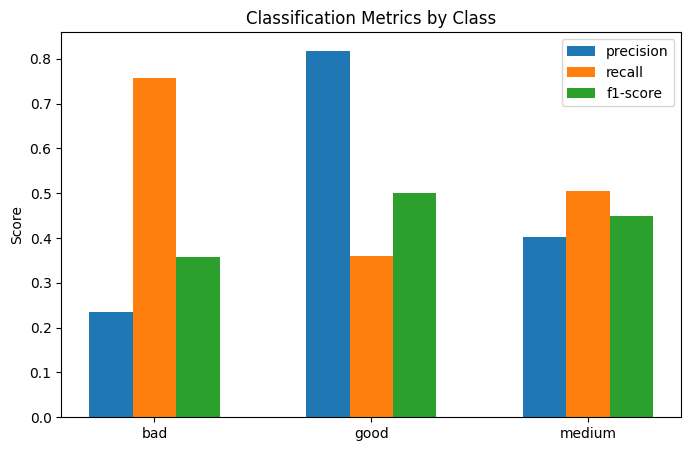

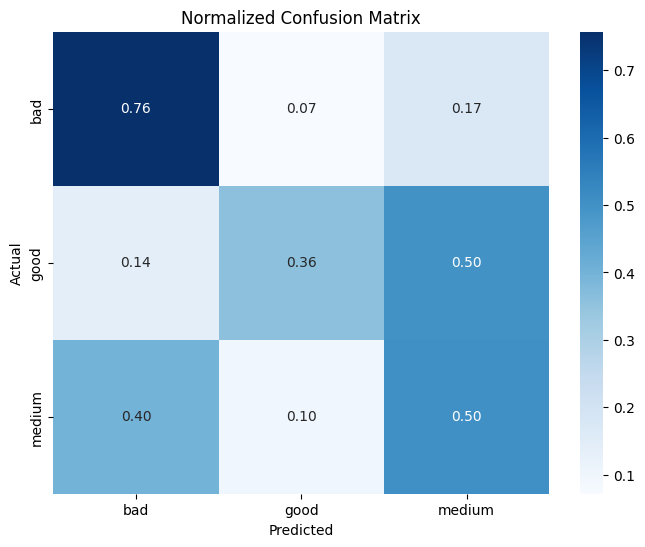

In [15]:

# Predictions with probability-based thresholding
y_pred_proba = model_air.predict_proba(X_test_encoded)
y_pred_encoded = model_air.predict(X_test_encoded)

# Adjust thresholds to catch more minority classes
# If "bad" (class 0) probability > 0.15, predict "bad"
# If "medium" (class 2) probability > 0.25, predict "medium" (unless "bad" is triggered)
y_pred_adjusted = y_pred_encoded.copy()
for i in range(len(y_pred_proba)):
    if y_pred_proba[i, 0] > 0.15:  # Adjusted threshold for "bad"
        y_pred_adjusted[i] = 0
    elif y_pred_proba[i, 2] > 0.25:  # Adjusted threshold for "medium"
        y_pred_adjusted[i] = 2

print("PREDICT (before threshold)", y_pred_encoded)
print("PREDICT (after threshold)", y_pred_adjusted)

# Decoding
y_pred = le_y.inverse_transform(y_pred_adjusted) # As labels
print("decoded", y_pred)

# Metrics
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'macro' or 'micro' if needed
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

print(f"Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}, Kappa = {kappa:.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot


metrics = ['precision', 'recall', 'f1-score']
classes = report_df.index[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
width = 0.2
x = np.arange(len(classes))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, report_df.loc[classes, metric], width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(classes)
ax.set_ylabel("Score")
ax.set_title("Classification Metrics by Class")
ax.legend()
plt.show()


from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


